In [1]:
import pennylane.numpy as np
import matplotlib.pyplot as plt
from qml_essentials.model import Model
from qml_essentials.coefficients import Coefficients

from matplotlib.colors import LogNorm

/home/maja/code/qml-essentials/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


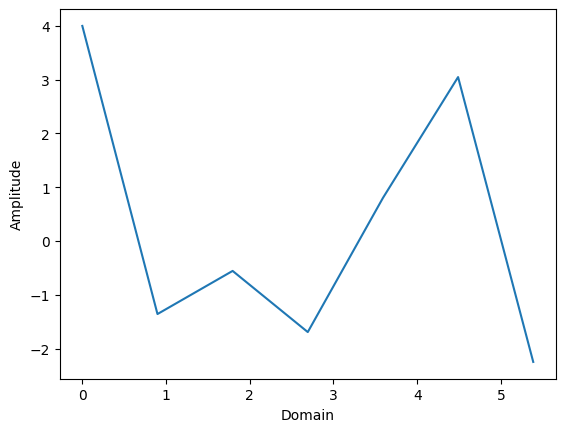

In [2]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = (2*max(f)+1,)
        self.frequencies = f
        self.n_input_feat = 1

    def __call__(self, inputs, **kwargs):
        return np.sum([c * np.exp(-1j * inputs * f) for f, c in zip(self.f, self.c)], axis=0)


freqs = [-3, -1.5, 0, 1.5, 3]
coeffs = [1, 1, 0, 1, 1]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs, freqs)

x = np.arange(0, 2 * np.pi, 2 * np.pi / fs)
out = model_fct(x)

fig, ax = plt.subplots()
ax.plot(x, out)
plt.xlabel("Domain")
plt.ylabel("Amplitude")
plt.savefig("figures/model_fct_light.png", dpi=100, transparent=True)
plt.show()

7


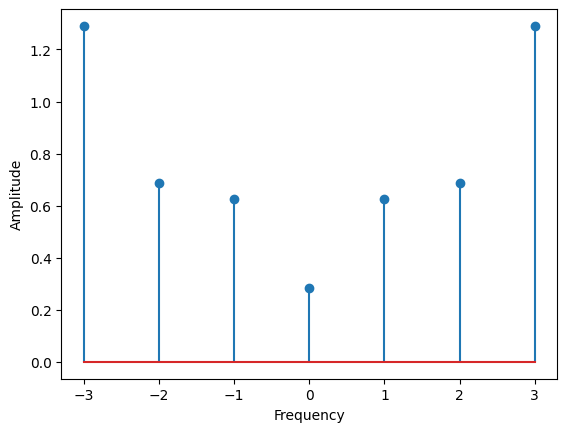

In [3]:
X = np.fft.fft(out)

X_freq = np.fft.fftfreq(X.size, 1 / fs)

if X.size % 2 == 0:
    X = np.delete(X, len(X) // 2)
    X_freq = np.delete(X_freq, len(X_freq) // 2)

print(len(X))
X_shift = np.fft.fftshift(X)
X_freq_shift = np.fft.fftshift(X_freq)

fig, ax = plt.subplots()
ax.stem(X_freq_shift, np.abs(X_shift) / X_shift.size)
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.savefig("figures/model_fct_spectr_light.png", dpi=100, transparent=True)
plt.show()

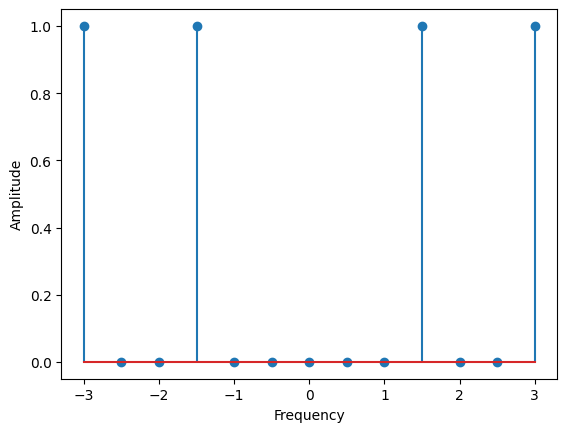

In [4]:
coeffs, freqs = Coefficients.get_spectrum(model_fct, mts=2, shift=True, trim=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.savefig("figures/model_fct_spectr_ours_light.png", dpi=100, transparent=True)
plt.show()

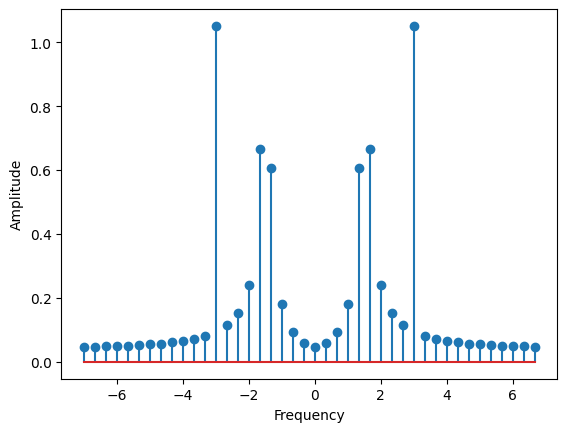

In [5]:
coeffs, freqs = Coefficients.get_spectrum(model_fct, mfs=2, mts=3, shift=True)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.savefig("figures/model_fct_spectr_os_light.png", dpi=100, transparent=True)
plt.show()

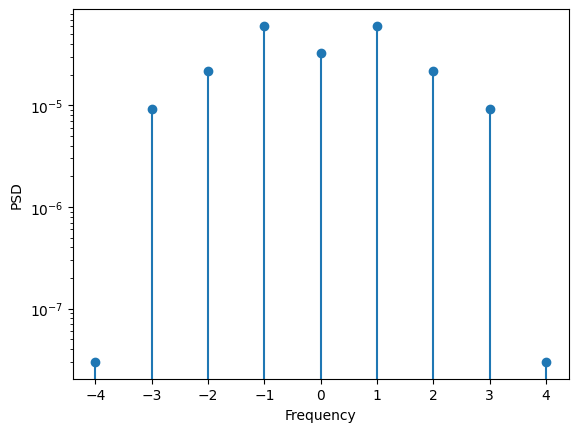

In [6]:
model = Model(n_qubits=4, n_layers=1, circuit_type="Circuit_19", random_seed=1000)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1, shift=True)

psd = Coefficients.get_psd(coeffs)

fig, ax = plt.subplots()
ax.stem(freqs, psd)
ax.set_yscale("log")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.savefig("figures/model_psd_light.png", dpi=100, transparent=True)
plt.show()

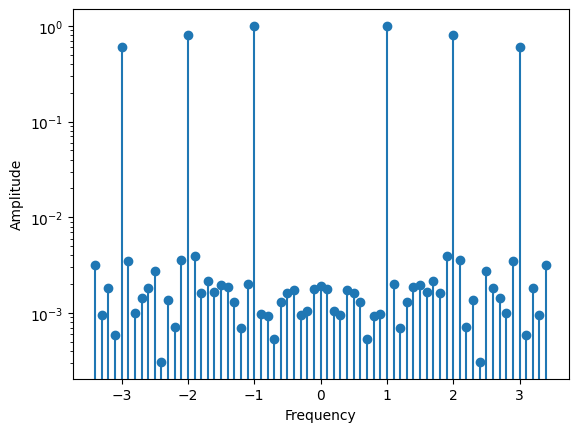

In [7]:
class Model_Fct:
    def __init__(self, c, f):
        self.c = c
        self.f = f
        self.degree = (2*max(f)+1,)
        self.frequencies = f
        self.rng = np.random.default_rng(1000)
        self.n_input_feat = 1

    def __call__(self, inputs, **kwargs):
        inputs = inputs.flatten()
        noise = self.rng.normal(0, 0.01, inputs.size)
        # noise = 0
        return np.sum(
            [c * np.cos(noise + ((inputs * f))) for f, c in zip(self.f, self.c)], axis=0
        )


freqs = [-3, 2, 1, 0, 1, 2, 3]
coeffs = [0.6, 0.8, 1, 0, 1, 0.8, 0.6]

fs = max(freqs) * 2 + 1
model_fct = Model_Fct(coeffs, freqs)

out = model_fct(x)

coeffs, freqs = Coefficients.get_spectrum(
    model_fct, mfs=1, mts=10, trim=True, shift=True
)

fig, ax = plt.subplots()
ax.stem(freqs, np.abs(coeffs))
ax.set_yscale("log")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [8]:
from qml_essentials.coefficients import FourierTree

model = Model(
    n_qubits=4, n_layers=1, circuit_type="Circuit_19", output_qubit=0, random_seed=1000
)
fft_coeffs, fft_freqs = Coefficients.get_spectrum(model, shift=True)
fft_psd = Coefficients.get_psd(fft_coeffs)

In [9]:
fourier_tree = FourierTree(model)
an_coeffs, an_freqs = fourier_tree.get_spectrum(force_mean=True)
an_psd = Coefficients.get_psd(an_coeffs[0])

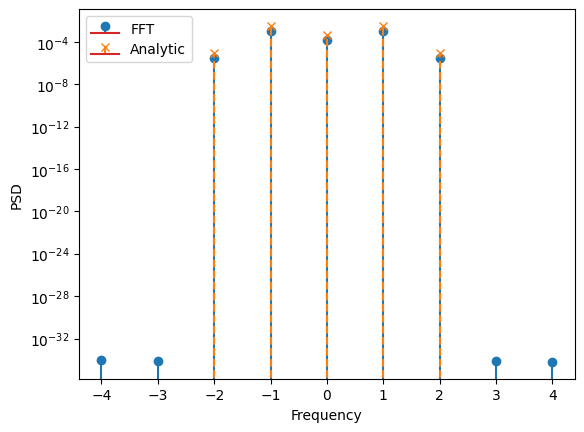

In [10]:
fig, ax = plt.subplots()
ax.stem(fft_freqs, fft_psd, label="FFT")
ax.stem(an_freqs[0], an_psd, linefmt="C1--", markerfmt="C1x", label="Analytic")
ax.set_yscale("log")
plt.xlabel("Frequency")
plt.ylabel("PSD")
plt.legend(loc="upper left")
plt.savefig("figures/model_psd_an_light.png", dpi=100, transparent=True)
plt.show()

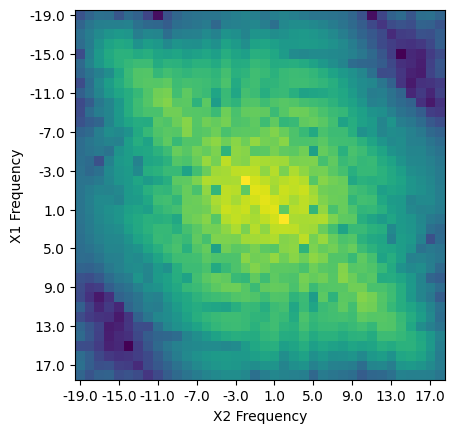

In [11]:
from matplotlib.colors import LogNorm
from qml_essentials.gates import Gates
import pennylane as qml
import numpy as np


def none_encoding(*args, **kwargs):
    return None


fact = 0.00001


def exp_encoding1(w, wires, noise_params):
    w = w + (np.random.rand(w.size) * fact * np.pi)
    Gates.CRX(w, [wires, (wires + 1) % 2])


def exp_encoding2(w, wires, noise_params):
    w = w + (np.random.rand(w.size) * fact * np.pi)
    Gates.RX(w, wires)


def cust_encoding(w, wires, noise_params):
    Gates.Rot(w, w, w, wires)


model = Model(
    n_qubits=3,
    n_layers=3,
    circuit_type="Hardware_Efficient",
    random_seed=1000,
    encoding=[cust_encoding, cust_encoding],
    use_multithreading=True,
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=2, mts=1, shift=True)

psd = Coefficients.get_psd(coeffs) + 1e-32
# psd = np.abs(coeffs.imag)

fig, ax = plt.subplots()
ax.imshow(psd, norm=LogNorm(vmin=psd.min(), vmax=psd.max()))
# ax.imshow(psd)
ax.set_xticks(np.arange(len(freqs[1]))[::4])
ax.set_yticks(np.arange(len(freqs[0]))[::4])
ax.set_xticklabels(freqs[1][::4])
ax.set_yticklabels(freqs[0][::4])
plt.xlabel("X2 Frequency")
plt.ylabel("X1 Frequency")
plt.savefig("figures/model_2d_psd_light.png", dpi=100, transparent=True)
plt.show()

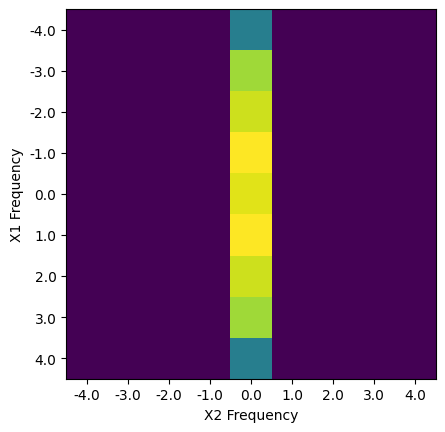

In [12]:
from qml_essentials.gates import Gates


def none_encoding(*args, **kwargs):
    return None


model = Model(
    n_qubits=4,
    n_layers=1,
    circuit_type="Circuit_19",
    random_seed=1000,
    encoding=[Gates.RX, none_encoding],
    use_multithreading=True,
)

coeffs, freqs = Coefficients.get_spectrum(model, mfs=1, mts=1, shift=True)

psd = Coefficients.get_psd(coeffs) + 1e-10

fig, ax = plt.subplots()
ax.imshow(psd, norm=LogNorm(vmin=psd.min(), vmax=psd.max()))
ax.set_xticks(np.arange(len(freqs[1])))
ax.set_yticks(np.arange(len(freqs[0])))
ax.set_xticklabels(freqs[1])
ax.set_yticklabels(freqs[0])
plt.xlabel("X2 Frequency")
plt.ylabel("X1 Frequency")
plt.show()

In [13]:
from qml_essentials.coefficients import FCC

model = Model(
    n_qubits=6,
    n_layers=1,
    circuit_type="Hardware_Efficient",
    output_qubit=-1,
    encoding=["RY"],
    use_multithreading=True,
)

fcc = FCC.get_fcc(
    model=model,
    n_samples=500,
    seed=1000,
    scale=True,
)

print(f"FCC: {fcc:.4f}")

/home/maja/code/qml-essentials/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:2608: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(


FCC: 0.1190


/home/maja/code/qml-essentials/.venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:2608: ComplexWarning: Casting complex values to real discards the imaginary part
  out_array: Array = lax_internal._convert_element_type(


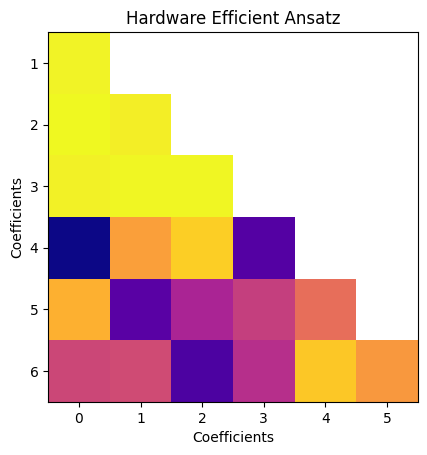

In [14]:
fp, _ = FCC.get_fourier_fingerprint(
    model=model,
    n_samples=500,
    seed=1000,
    scale=True,
    trim_redundant=True,
)

fp = np.abs(fp)

Sunset = [
    "rgb(243, 231, 155)",
    "rgb(250, 196, 132)",
    "rgb(248, 160, 126)",
    "rgb(235, 127, 134)",
    "rgb(206, 102, 147)",
    "rgb(160, 89, 160)",
    "rgb(92, 83, 165)",
]

fig, ax = plt.subplots()
ax.imshow(fp, cmap="plasma_r")
ax.set_xticks(np.arange(fp.shape[1]))
ax.set_yticks(np.arange(fp.shape[1]))
ax.set_xticklabels(list(range(0, 6)))
ax.set_yticklabels(list(range(1, 7)))
plt.title("Hardware Efficient Ansatz")
plt.xlabel("Coefficients")
plt.ylabel("Coefficients")
plt.savefig("figures/fourier_fingerprint_light.png", dpi=100, transparent=True)
plt.show()